In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

In [3]:
import pandas as pd
import numpy as np
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as npimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline
import json
import os
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input

from tensorflow.keras.preprocessing.image import load_img


In [4]:
train_dir='/kaggle/input/dog-breed-identification/train/'
test_dir='/kaggle/input/dog-breed-identification/test/'


In [5]:
test_dir

'/kaggle/input/dog-breed-identification/test/'

In [6]:
labels_df=pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
sample_df=pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')


In [7]:
labels_df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
labels_df.shape

(10222, 2)

In [9]:
print(f"Number of pic in train_dir {len(os.listdir(train_dir))}")
print(f"Number of pic in test_dir {len(os.listdir(test_dir))}")

Number of pic in train_dir 10222
Number of pic in test_dir 10357


In [10]:
dog_breeds=sorted(labels_df['breed'].unique())
n_classes=len(dog_breeds)


In [11]:
class_to_num= dict(zip(dog_breeds, range(n_classes)))
class_to_num


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [12]:
img1=(train_dir+labels_df.id+'.jpg')[11]
img1


'/kaggle/input/dog-breed-identification/train/0067dc3eab0b3c3ef0439477624d85d6.jpg'

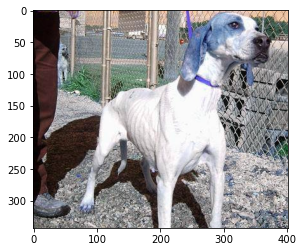

In [13]:
img=cv2.imread((img1))
plt.imshow(img)


In [14]:
labels_df['file_path']= labels_df['id'].apply(lambda x:train_dir+f'{x}.jpg')

In [15]:
labels_df.head()


,id,breed,file_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/kaggle/input/dog-breed-identification/train/0...


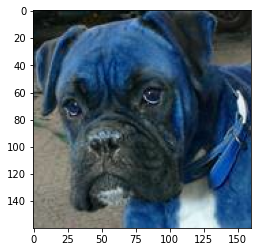

In [16]:
plt.imshow(cv2.imread(labels_df['file_path'][19]))

In [17]:
labels_df['breed']=labels_df.breed.map(class_to_num)
labels_df.head()


,id,breed,file_path
0,000bec180eb18c7604dcecc8fe0dba07,19,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,85,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,15,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,49,/kaggle/input/dog-breed-identification/train/0...


In [18]:
from tensorflow.keras.utils import to_categorical


In [19]:
y = to_categorical(labels_df.breed)
y[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,Activation


In [21]:
input_shape = (331,331,3)
input_layer = Input(shape=input_shape)


In [22]:
#first extractor inception_resnet
preprocessor_resnet = Lambda(resnet_preprocess)(input_layer)
inception_resnet = InceptionResNetV2(weights = 'imagenet',
include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)


#second extractor InceptionV3
preprocessor_inception = Lambda(inception_preprocess)(input_layer)
inception_v3 = InceptionV3(weights = 'imagenet',
include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)
#Third extractor Xception
preprocessor_xception = Lambda(xception_preprocess)(input_layer)
xception = Xception(weights = 'imagenet',
include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)
#fourth extractor nasnet large
preprocessor_nasnet = Lambda(nasnet_preprocess)(input_layer)
nasnet = NASNetLarge(weights = 'imagenet',
include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_nasnet)

2023-02-04 14:58:13.837309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 14:58:13.838284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 14:58:13.958046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 14:58:13.959014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 14:58:13.959900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

343621632/343610240 [==============================] - 3s 0us/step


In [23]:
merge = concatenate([inception_v3, xception,nasnet,inception_resnet])
model = Model(inputs = input_layer, outputs = merge)


In [24]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

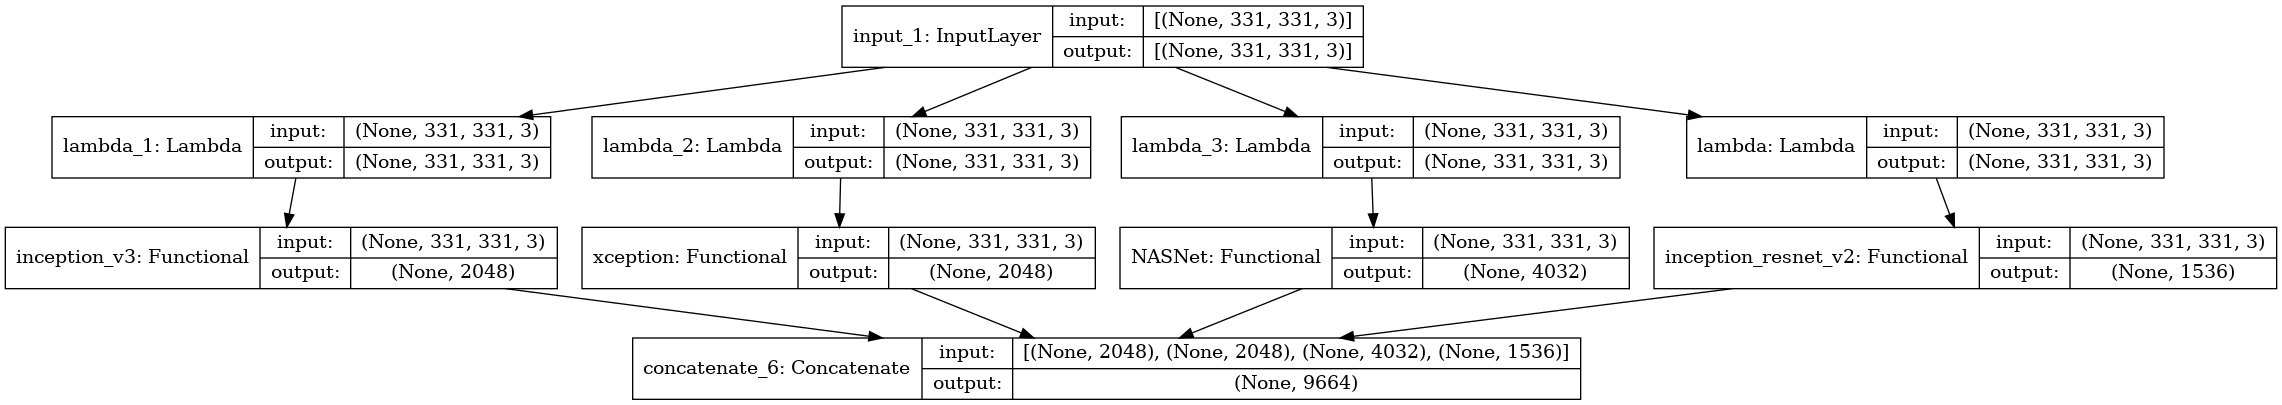

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)



In [26]:
len(model.trainable_weights)


1846

In [27]:
# for feature_extraction dataframe must have to contain file_name and breed columns
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,9664], dtype=np.uint8)
    # y = np.zeros([data_size,120], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_path', class_mode = None,
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
            break
    return X


In [28]:
n_classes

120

In [30]:
X = feature_extractor(labels_df)

Found 10222 validated image filenames.


100%|█████████▉| 511/512 [12:57<00:01,  1.52s/it]


In [32]:
X.shape

(10222, 9664)

In [33]:
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

In [38]:
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/checkpoing',
monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

In [39]:
dnn = keras.models.Sequential([
InputLayer(X.shape[1:]),
Dropout(0.7),
Dense(n_classes, activation='softmax')
])

In [40]:
dnn.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(X , y,
batch_size=128,
epochs=60,
validation_split=0.1 ,
callbacks = my_callback)

Epoch 1/60
72/72 [==============================] - 1s 5ms/step - loss: 3.8996 - accuracy: 0.5570 - val_loss: 2.8017 - val_accuracy: 0.9179
Epoch 2/60
72/72 [==============================] - 0s 4ms/step - loss: 2.1031 - accuracy: 0.9033 - val_loss: 1.5475 - val_accuracy: 0.9267
Epoch 3/60
72/72 [==============================] - 0s 4ms/step - loss: 1.2740 - accuracy: 0.9298 - val_loss: 1.0329 - val_accuracy: 0.9286
Epoch 4/60
72/72 [==============================] - 0s 4ms/step - loss: 0.9135 - accuracy: 0.9369 - val_loss: 0.7879 - val_accuracy: 0.9326
Epoch 5/60
72/72 [==============================] - 0s 4ms/step - loss: 0.7249 - accuracy: 0.9448 - val_loss: 0.6470 - val_accuracy: 0.9335
Epoch 6/60
72/72 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.9486 - val_loss: 0.5589 - val_accuracy: 0.9335
Epoch 7/60
72/72 [==============================] - 0s 4ms/step - loss: 0.5077 - accuracy: 0.9564 - val_loss: 0.4975 - val_accuracy: 0.9316
Epoch 8/60
72/72 [==

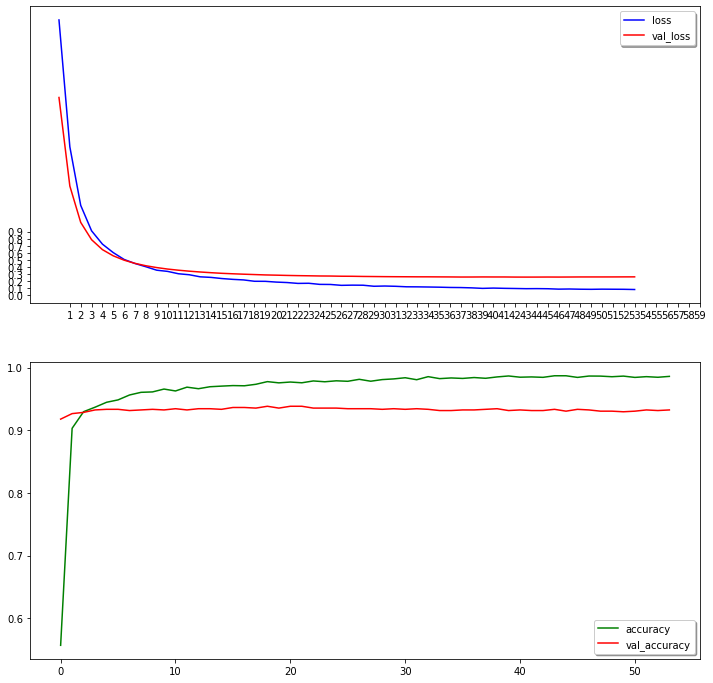

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)
ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
# ax2.set_xticks(np.arange(1, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 0.1))
plt.show()


In [43]:
test_data = []
ids=[]
for pic in os.listdir(test_dir):
    ids.append(pic.split('.')[0])
    test_data.append(test_dir+pic)

In [44]:
test_data[:5]

['/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg']

In [45]:
test_dataframe = pd.DataFrame({'file_path':test_data})
test_dataframe


,file_path
0,/kaggle/input/dog-breed-identification/test/09...
1,/kaggle/input/dog-breed-identification/test/f7...
2,/kaggle/input/dog-breed-identification/test/bc...
3,/kaggle/input/dog-breed-identification/test/7c...
4,/kaggle/input/dog-breed-identification/test/f3...
...,...
10352,/kaggle/input/dog-breed-identification/test/d2...
10353,/kaggle/input/dog-breed-identification/test/e6...
10354,/kaggle/input/dog-breed-identification/test/54...
10355,/kaggle/input/dog-breed-identification/test/06...


In [46]:
test_features = feature_extractor(test_dataframe)

Found 10357 validated image filenames.


100%|█████████▉| 517/518 [13:16<00:01,  1.54s/it]


In [47]:
y_pred = dnn.predict(test_features)

In [48]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(y_pred, axis = 1)
pred_codes


array([104,  89,  69, ...,  60,  44,  70])

In [49]:
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))

In [50]:
predictions[:5]

['staffordshire_bullterrier',
 'redbone',
 'leonberg',
 'italian_greyhound',
 'welsh_springer_spaniel']

In [51]:
test_dataframe['breed'] = predictions
test_dataframe

,file_path,breed
0,/kaggle/input/dog-breed-identification/test/09...,staffordshire_bullterrier
1,/kaggle/input/dog-breed-identification/test/f7...,redbone
2,/kaggle/input/dog-breed-identification/test/bc...,leonberg
3,/kaggle/input/dog-breed-identification/test/7c...,italian_greyhound
4,/kaggle/input/dog-breed-identification/test/f3...,welsh_springer_spaniel
...,...,...
10352,/kaggle/input/dog-breed-identification/test/d2...,komondor
10353,/kaggle/input/dog-breed-identification/test/e6...,great_pyrenees
10354,/kaggle/input/dog-breed-identification/test/54...,italian_greyhound
10355,/kaggle/input/dog-breed-identification/test/06...,flat-coated_retriever


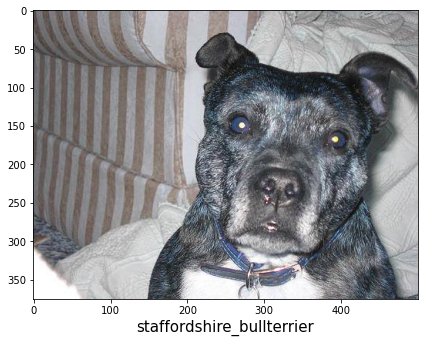

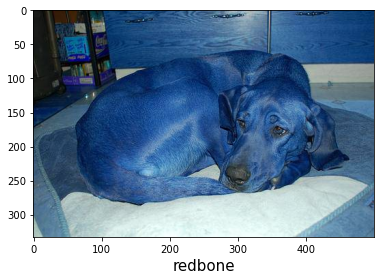

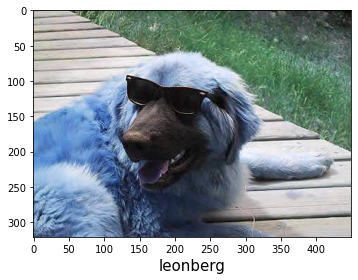

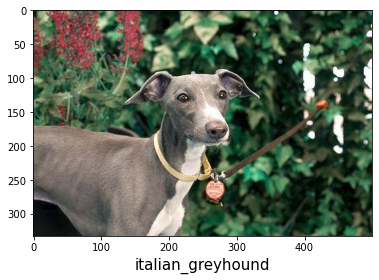

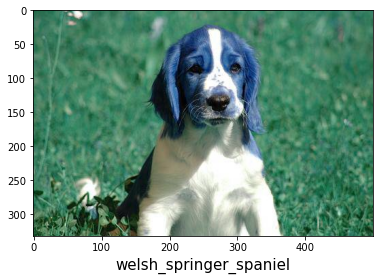

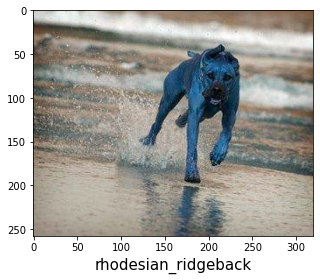

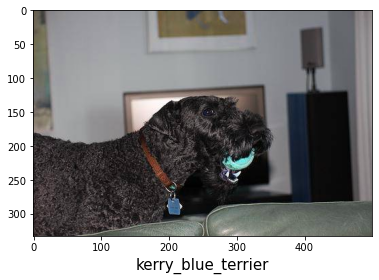

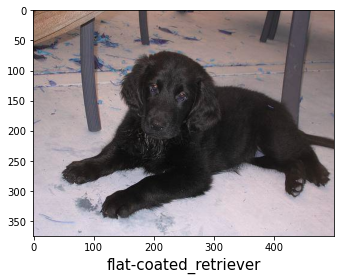

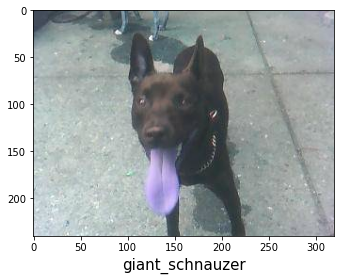

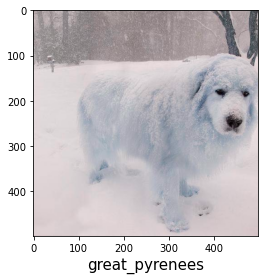

In [53]:
plt.figure(figsize=(6,6))

for index , data in test_dataframe[:10].iterrows():
    img = data['file_path']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()
    